<div class="alert alert-success">
<b>Reviewer's comment V3</b>
	  
Thank you for taking the time to improve the project! It's accepted now. Good luck on the next sprint! :)
    
</div>

**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a pretty good job overall, but unfortunately there are a couple of problems that need to be fixed before the project can be accepted. Good luck!


# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
!pip install scikit-learn --upgrade
!pip install optuna



Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.2 MB 129 kB/s eta 0:00:01    |█████████████▊                  | 10.0 MB 1.3 MB/s eta 0:00:10
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 308 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 6.7 MB/s  eta 0:00:01
     |████████████████████████████████| 111 kB 24.4 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 2.8 MB/s  eta 0:00:01
     |████████████████████████████████| 144 kB 23.9 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11106 sha256=ad5d2637d7938236d1175a89788692d532c94d2ea0895cd3338e5efb024f83a2
  Stored in directory: /home/jovyan/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
  Consider adding this directory to PATH or, if you prefer to suppr

In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

#packages for hyperparameter choice
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3675,1,35.0,46200.0,1,0
3722,0,21.0,21400.0,0,0
2939,0,37.0,21400.0,0,0
410,0,32.0,39700.0,1,0
2185,0,25.0,58000.0,0,0
2159,0,34.0,37300.0,4,0
2818,0,52.0,40700.0,0,2
1654,0,44.0,38400.0,1,1
3964,1,24.0,40600.0,1,0
2644,1,33.0,40000.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int')

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

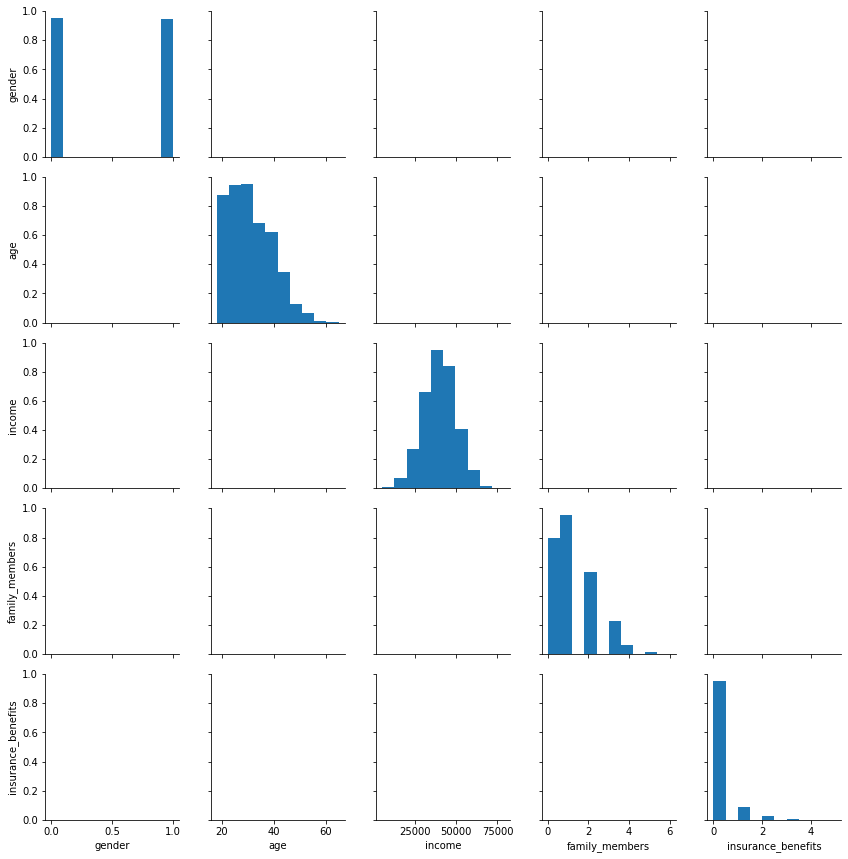

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k,metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The function for getting k nearest neighbors is correct!
	  
</div>

Scaling the data.

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1028,1.0,0.353846,0.491139,0.500000,0
3097,1.0,0.446154,0.670886,0.000000,0
1626,1.0,0.569231,0.449367,0.166667,0
4398,0.0,0.476923,0.455696,0.000000,0
4838,1.0,0.784615,0.375949,0.000000,2


Now, let's get similar records for a given one for every combination

In [15]:
euc_seuc = 0
euc_man = 0
seuc_sman = 0
sman_man = 0
for n in range(len(df)):
    df_euclidean = get_knn(df,n,5,'euclidean')
    df_scaled_euclidean = get_knn(df_scaled,n,5,'euclidean')
    df_manhattan = get_knn(df,n,5,'manhattan')
    df_scaled_manhattan = get_knn(df_scaled,n,5,'manhattan')
    if np.array_equal(np.sort(np.array(df_euclidean.index)),np.sort(np.array(df_scaled_euclidean.index))) == True:
        euc_seuc += 1
    if np.array_equal(np.sort(np.array(df_euclidean.index)),np.sort(np.array(df_manhattan.index))) == True:
        euc_man += 1
    if np.array_equal(np.sort(np.array(df_scaled_euclidean.index)),np.sort(np.array(df_scaled_manhattan.index)))== True:
        seuc_sman += 1
    if np.array_equal(np.sort(np.array(df_scaled_manhattan.index)),np.sort(np.array(df_manhattan.index)))== True:
        sman_man += 1
print(
    'Percent of obsersvations with the exact same 5 nearest neighbors for:', '\n' 
    'Euclidean and Scaled Euclidean Datasets:', round(euc_seuc/len(df)*100,2), '\n'
    'Euclidean and Manhattan Datasets:',round(euc_man/len(df)*100,2), '\n'
    'Scaled Euclidean and Scaled Manhattan Datasets:',round(seuc_sman/len(df)*100,2), '\n'
    'Manhattan and Scaled Manhattan Datasets:',round(sman_man/len(df)*100,2))
    

KeyboardInterrupt: 

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

It clearly has an effect on the algorithm because it is very rare that the scaled and non-scaled datasets return the same 5 nearest neighbors. This is because when you scale the data it will change the distances between observations. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Changing the distance measurement did not have nearly the same effect as scaling the data. As you can see above, changing the distance measurement, in the non-scaled data, only changed 25% of the top 5 nearest neighbors. Even in the scaled data, over 60% of the observations had the same 5 nearest neighbors for both distance measurements. The reason the scaled data has a lower percentage of observations with the same 5 nearest neighbors is due to the fact that all the observations are clumped closer together.  

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
Ok! The main difference between kNN on scaled and unscaled data is that on unscaled data if some feature has a much bigger magnitude than others, it will dominate the metric. Due to this reason, distance-based algorithms like kNN are sensitive to scales of features.
	  
</div>

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [16]:
# calculate the target
df['insurance_benefits_received'] = df['insurance_benefits']/df['insurance_benefits']

df['insurance_benefits_received'].fillna(0,inplace=True)

target = df['insurance_benefits_received']
features = df.drop(['insurance_benefits_received','insurance_benefits'],axis=1)


features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [22]:
# calculate the target
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits']/df_scaled['insurance_benefits']

df_scaled['insurance_benefits_received'].fillna(0,inplace=True)

target_scaled = df_scaled['insurance_benefits_received']
features_scaled = df_scaled.drop(['insurance_benefits_received','insurance_benefits'],axis=1)


features_train_scaled, features_test_scaled, target_train_scaled, target_test_scaled = train_test_split(features_scaled, target_scaled, test_size=0.3, random_state=42)



In [17]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0.0    4436
1.0     564
Name: insurance_benefits_received, dtype: int64

In [18]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [19]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [20]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P,len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [24]:
def KNN_objective(trial):
    #defining ranges for decison tree optimization
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10,1)
    #creating model
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(features_train,target_train)
    target_pred = model.predict(features_test)
    f1_score = sklearn.metrics.f1_score(target_test, target_pred)
    #returning the score that compares the predicted validation targets to the actual validation targets
    return f1_score
#creating the study to optimize the hyperparameters
study_knn = optuna.create_study(direction='maximize',sampler=TPESampler(seed=15))
study_knn.optimize(KNN_objective, n_trials=100)

#printing the highest f1_score
print('Highest F1 score for non-scaled data',study_knn.best_value)
print(study_knn.best_params)

def KNN_scaled_objective(trial):
    #defining ranges for decison tree optimization
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10,1)
    #creating model
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(features_train_scaled,target_train_scaled)
    target_pred_scaled = model.predict(features_test_scaled)
    f1_score = sklearn.metrics.f1_score(target_test_scaled, target_pred_scaled)
    #returning the score that compares the predicted validation targets to the actual validation targets
    return f1_score
#creating the study to optimize the hyperparameters
study_knn_scaled = optuna.create_study(direction='maximize',sampler=TPESampler(seed=15))
study_knn_scaled.optimize(KNN_scaled_objective, n_trials=100)

#printing the highest f1_score
print('Highest F1 score for scaled data',study_knn_scaled.best_value)
print(study_knn_scaled.best_params)


Highest F1 score for non-scaled data 0.65
{'n_neighbors': 1}
Highest F1 score for scaled data 0.9392971246006389
{'n_neighbors': 3}


**The results above show that the KNeighborsClassifier model performs best when looking at the three closest neighbors using the scaled data.**   

<div class="alert alert-danger">
<b>Reviewer's comment</b>
	  
Ok! The task is not quite complete though. The task requires you to:
 
1. try different value of `n_neighbors` from 1 to 10, but it looks like you only tried one value (the default one)
2. try fitting the model using original and scaled data and compare the results, but you only tried it on unscaled data
	  
</div>

<div class="alert alert-danger">
<b>Reviewer's comment V2</b>
	  
Looks like you accidentally used unscaled data both times:
    
```python
study_knn.optimize(KNN_objective, n_trials=500)
```
    
</div>

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [ ]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights) 
        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

In [ ]:
X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train_scaled)
print(lr.weights)

y_test_pred_scaled = lr.predict(X_test_scaled)
eval_regressor(y_test_scaled, y_test_pred_scaled)

**As you can see above, there is no difference between the RMSE and R2 values with the scaled and unscaled data. This shows that for linear regressions, scaling is not necessary.**

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you correctly implemented linear regression and compared its results on scaled and unscaled data
	  
</div>

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Mupliplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [ ]:
#checking if it is invertible
P_inv = np.linalg.inv(P)
#transforming the data
transformed_data = X @ P
print(transformed_data)

Can you guess the customers' ages or income after the transformation?

**No, it is impossible to find out this information without the key matrix (P).** 

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [ ]:
#X x P x P_inv = X
recovered_data = transformed_data @ P_inv
print(recovered_data)

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [ ]:
print('Original Data')
print(X[:4])
print('Transformed Data')
print(transformed_data[:4])
print('Recovered Data')
print(recovered_data[:4])

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

**This would be due to rounding errors.** 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Yeah, pretty much!
	  
</div>

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

- $w_p$ is equal to $P^{-1}w$ as seen below:
$$
\begin{align*}
w_P &= [(XP)^T XP]^{-1} (XP)^T y & \text{by the solved value of regression weights}\\
    &= [P^T X^T X P]^{-1} P^T X^T y & \text{by the reversivity of the transpose of a product of matrices} \\
    &= P^{-1} (X^{T} X)^{-1} (P^{T})^{-1} P^T X^T y & \text{by the third multiplicative identity property of matrices}\\ 
    &= P^{-1} (X^{T} X)^{-1} X^T y & \text{by the second multiplicative identity property of matrices}\\ 
    &= P^{-1} w & \text{by the solved value of regression weights}
\end{align*}
$$
- $\hat{y}$ with Obfuscation is $XPw_P$ and without is $Xw$, yet the proof below shows those are the exact same values.   
$$
\begin{align*}
\hat{y} &= XPw_P & \text{by the solved value of target predictions}\\
    &= X P P^{-1} w  & \text{from the proof above}\\
    &= X w & \text{by the second multiplicative identity property of matrices}\\ \\ 
\end{align*}
$$
- The RMSE will be the exact same as the $\hat{y}$ values are the same.

**Analytical proof**

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>
	  
> $w_p$ is just $w$ multiplied by $P^{-1}$
    
That is correct, but there are two different ways to multiply $w$ by $P^{-1}$: $P^{-1}w$ and $w P^{-1}$. Which one is it? Also could you prove it please (don't forget properties of matrices listed at the end of the notebook)?
    
> The predicted values are just $X_{val}wP^{-1}$
    
Are you sure that it is a correct expression? What will the shape of such a product be?
    
> The RMSE will be the exact same as the P matrix just shifted the values and did not change the distance between them.
    
I don't really see how that follows from the previous lines. As I see it, the easiest way to prove that the quality won't change is to prove that predictions will be the same. As predictions equal $\hat{y} = Xw$, the predictions of the model trained on obfuscated data will be $\hat{y_p} = X_p w_p$, so we just need to plug in the expressions for $X_p$ and $w_p$ and compare the resulting $\hat{y_p}$ with $\hat{y}$
	  
</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>
	  
Ok, very good! One minor correction: when you're inversing the product $P^T X^T X P$, you should treat $X^T X$ as a single matrix, like this:
$$[P^T X^T X P]^{-1} = P^{-1} (X^T X)^{-1} (P^T)^{-1}.$$
    
The reason is that $X$ (and $X^T$) is not invertible: it's not even square almost always, because the number of examples (the number of rows) is almost always much bigger than the number of features (the number of columns). And only square matrices can be invertible. This means that $X^{-1}$ is not defined.
    
By the way, this is basically the reason the training formula is $w = (X^T X)^{-1} X^T y$, and not just $w = X^{-1} y$ (the second formula only works if $X$ is invertible). If you ever wondered where the $(X^T X)^{-1} X^T$ comes from, here's an idea. We know that $y = Xw$, and we would like to figure out what $w$ is equal to, but we can't just multiply both sides by $X^{-1}$ to do it, as $X$ is almost always not invertible. But if we multiply both sides by $X^T$: $$X^T X w = X^T y,$$ then $X^T X$ is always square and almost always invertible (as long as there are no linearly dependent columns), so we can multiply both sides by $(X^T X)^{-1}$ to express $w$: $$w = (X^T X)^{-1} X^T y.$$
    

	  
</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>
	  
Excellent, now everything is correct!
    
</div>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Multiply the matrices to get $XP$
- Use $XP$ as the new feature matrix

In [ ]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
        
    def obfuscation(self,X):
            n = 0
            P = np.random.default_rng(n).random(size=(X.shape[1], X.shape[1]))
            P_inv = None
            while P_inv is None:
                try: 
                    P_inv = np.linalg.inv(P)
                except:
                    pass
                n = n+1
            self.XP = X @ P
    
    def fit(self, X, y):
        
        # adding the unities
        try:
            X = self.XP
        except:
            X = X
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights) 
        return y_pred

In [ ]:
model = MyLinearRegression()
model.obfuscation(X_train) 
model.fit(X_train,y_train)
y_test_pred = model.predict(X_test)
eval_regressor(y_test, y_test_pred)

In [ ]:
model_2 = MyLinearRegression()
model_2.fit(X_train,y_train)
y_test_pred_2 = model_2.predict(X_test)
eval_regressor(y_test, y_test_pred_2)

**There are no differences in the RMSE and R2 values when using obfuscation.**

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you successfully validated our data obfuscation algorithm empirically.
	  
</div>

# Conclusions

In this project, I helped Sure Tomorrow Insurance answer questions about how they can use Machine Learning. I started out by creating a function to find customers who are similar to a given customer. I then showed that for a given customer scaling the data has a much larger effect on the chosen similar customers than the measurement technique. 

Next, compared 4 random classification models to a kNN classification model for both the original and scaled data. This showed that, due to the large class imbalance, a kNN model would need some sort of resampling to be effective. 

Lastly, I showed that linear regressions can be transformed without any changes in the resulting RMSE and R2 values. This provides Sure Tomorrow with a model that can use obfuscated data to help protect the privacy of their clients.

Overall, I recommend that Sure Tomorrow Insurance uses a linear regression model with obfuscation to predict the number of insurance benefits a new customer is likely to receive while also protecting their privacy. 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Ok, well done!
	  
</div>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>